In [20]:

# %%
# 1. Kütüphaneler ve Ayarlar
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from collections import Counter
import time
import copy
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"✅ Kullanılan Cihaz: {device}")

NUM_CLASSES = 4
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
SEED = 42

DATA_DIR = 'C:/Users/Muhammet/Desktop/DerinÖğrenme_Projesi/archive/Multi-class Weather Dataset'

def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

set_seed(SEED)

✅ Kullanılan Cihaz: cuda:0


Train: {1: 130, 3: 214, 0: 180, 2: 152}
Val  : {1: 44, 3: 71, 2: 50, 0: 60}
Test : {1: 43, 3: 72, 0: 60, 2: 51}


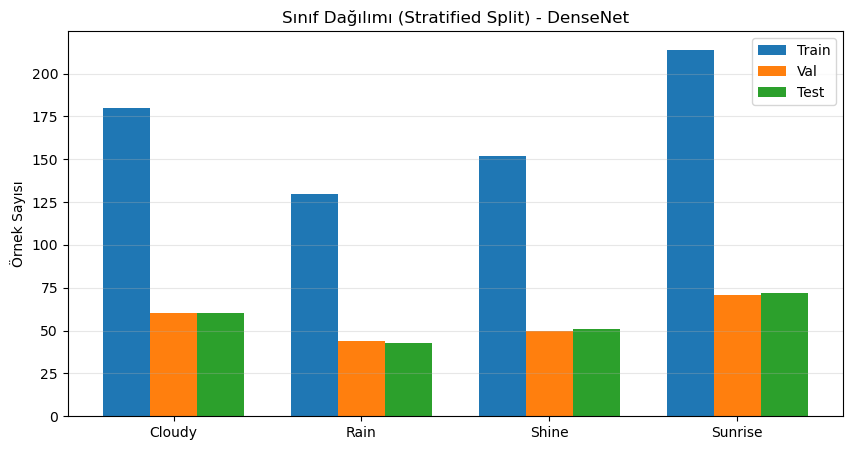

📂 Sınıflar: ['Cloudy', 'Rain', 'Shine', 'Sunrise']
📊 Dağılım: Train=676, Val=225, Test=226


In [21]:
# %%
# 2. Veri Yükleme, Augmentation ve STRATIFIED SPLIT
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

try:
    full_dataset = datasets.ImageFolder(DATA_DIR, transform=None)
except FileNotFoundError:
    print("❌ HATA: Veri yolu bulunamadı.")

targets = full_dataset.targets

train_idx, temp_idx = train_test_split(
    np.arange(len(targets)), test_size=0.4, shuffle=True, stratify=targets, random_state=SEED
)

temp_targets = np.array(targets)[temp_idx]

val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, shuffle=True, stratify=temp_targets, random_state=SEED
)

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

def count_classes_subset(dataset, full_targets):
    indices = dataset.indices
    labels = [full_targets[i] for i in indices]
    return Counter(labels)

train_c = count_classes_subset(train_dataset, full_dataset.targets)
val_c   = count_classes_subset(val_dataset, full_dataset.targets)
test_c  = count_classes_subset(test_dataset, full_dataset.targets)

print("Train:", dict(train_c))
print("Val  :", dict(val_c))
print("Test :", dict(test_c))

x = np.arange(NUM_CLASSES)
w = 0.25
class_names = full_dataset.classes

plt.figure(figsize=(10,5))
plt.bar(x-w, [train_c[i] for i in range(NUM_CLASSES)], w, label="Train")
plt.bar(x,   [val_c[i]   for i in range(NUM_CLASSES)], w, label="Val")
plt.bar(x+w, [test_c[i]  for i in range(NUM_CLASSES)], w, label="Test")
plt.xticks(x, class_names)
plt.ylabel("Örnek Sayısı")
plt.title("Sınıf Dağılımı (Stratified Split) - DenseNet")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

train_dataset = TransformDataset(train_dataset, transform=train_transform)
val_dataset   = TransformDataset(val_dataset,   transform=val_test_transform)
test_dataset  = TransformDataset(test_dataset,  transform=val_test_transform)

use_pin_memory = True if device.type == 'cuda' else False
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=use_pin_memory),
    'val'  : DataLoader(val_dataset,   batch_size=32,        shuffle=False, num_workers=0, pin_memory=use_pin_memory),
    'test' : DataLoader(test_dataset,  batch_size=32,        shuffle=False, num_workers=0, pin_memory=use_pin_memory)
}

dataset_sizes = {'train': len(train_idx), 'val': len(val_idx), 'test': len(test_idx)}
print(f"📂 Sınıflar: {class_names}")
print(f"📊 Dağılım: Train={len(train_idx)}, Val={len(val_idx)}, Test={len(test_idx)}")


📥 DenseNet121 Modeli Yükleniyor...
Epoch 1/20 | Train Loss: 0.5610 Acc: 0.8210 | Val Loss: 0.1487 Acc: 0.9689
| Train Loss: 0.1575 Acc: 0.9571 | Val Loss: 0.0686 Acc: 0.9911
Epoch 3/20 | Train Loss: 0.1260 Acc: 0.9689 | Val Loss: 0.0705 Acc: 0.9822
| Train Loss: 0.0997 Acc: 0.9704 | Val Loss: 0.0589 Acc: 0.9867
| Train Loss: 0.0642 Acc: 0.9837 | Val Loss: 0.0382 Acc: 0.9911
| Train Loss: 0.0684 Acc: 0.9778 | Val Loss: 0.0608 Acc: 0.9778
| Train Loss: 0.0698 Acc: 0.9822 | Val Loss: 0.0351 Acc: 0.9867
| Train Loss: 0.0305 Acc: 0.9985 | Val Loss: 0.0328 Acc: 0.9867
| Train Loss: 0.0516 Acc: 0.9852 | Val Loss: 0.0328 Acc: 0.9956
| Train Loss: 0.0466 Acc: 0.9882 | Val Loss: 0.0406 Acc: 0.9911
| Train Loss: 0.0405 Acc: 0.9926 | Val Loss: 0.0687 Acc: 0.9778
| Train Loss: 0.0542 Acc: 0.9882 | Val Loss: 0.0371 Acc: 0.9867
| Train Loss: 0.0302 Acc: 0.9926 | Val Loss: 0.0265 Acc: 0.9911
| Train Loss: 0.0282 Acc: 0.9896 | Val Loss: 0.0395 Acc: 0.9911
| Train Loss: 0.0319 Acc: 0.9911 | Val Loss: 0.

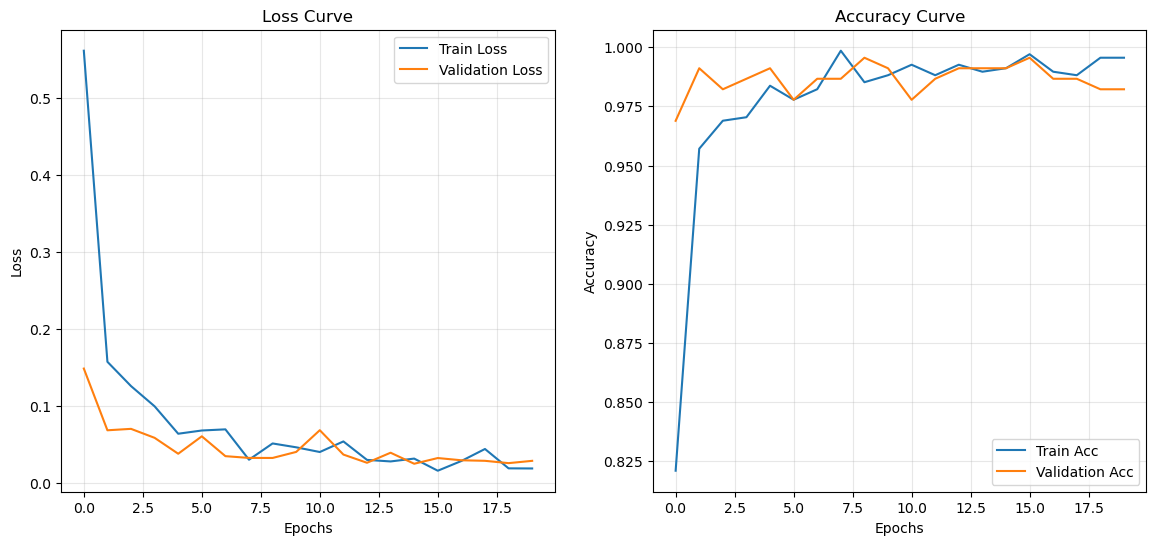

In [22]:
# %%
# 3. DenseNet121 Model Kurulumu
print("📥 DenseNet121 Modeli Yükleniyor...")
model_ft = models.densenet121(weights='DEFAULT')

num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, NUM_CLASSES)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)


# %%
# 4. Eğitim ve Grafikler
def train_model(model, criterion, optimizer, num_epochs=20):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}', end=' ')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc  = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
                print(f'| Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}', end=' ')
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                print(f'| Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc.item()
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'\n🏆 En İyi Val Accuracy: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history

model_ft, hist = train_model(model_ft, criterion, optimizer_ft, NUM_EPOCHS)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(hist['train_loss'], label='Train Loss')
plt.plot(hist['val_loss'],   label='Validation Loss')
plt.title('Loss Curve'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(hist['train_acc'], label='Train Acc')
plt.plot(hist['val_acc'],   label='Validation Acc')
plt.title('Accuracy Curve'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True, alpha=0.3)
plt.show()


In [23]:
# 5. Detaylı Performans Analizi (Test Seti)
def evaluate_detailed(model, dataloader, class_names):
    model.eval()
    y_true, y_pred, y_score = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_score.extend(probs.cpu().numpy())
    
    y_true, y_pred, y_score = np.array(y_true), np.array(y_pred), np.array(y_score)

    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (DenseNet121)'); plt.show()

   # Sınıflandırma Raporu
from sklearn.metrics import classification_report

# Model değişken adını kontrol edin (genellikle model_ft veya model)
# Eğer hata alırsanız 'model_ft' yerine 'model' yazmayı deneyin.
model_ft.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Sınıflandırma Raporu ---")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))




    



Sınıflandırma Raporu ---
              precision    recall  f1-score   support

      Cloudy     0.9831    0.9667    0.9748        60
        Rain     0.9773    1.0000    0.9885        43
       Shine     1.0000    0.9804    0.9901        51
     Sunrise     0.9863    1.0000    0.9931        72

    accuracy                         0.9867       226
   macro avg     0.9867    0.9868    0.9866       226
weighted avg     0.9868    0.9867    0.9867       226



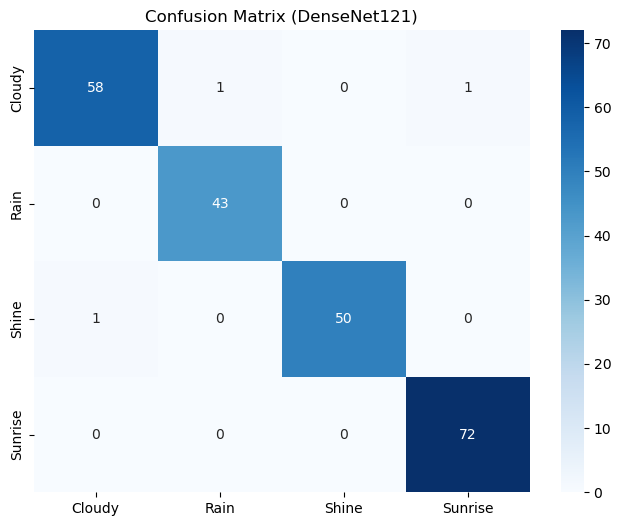

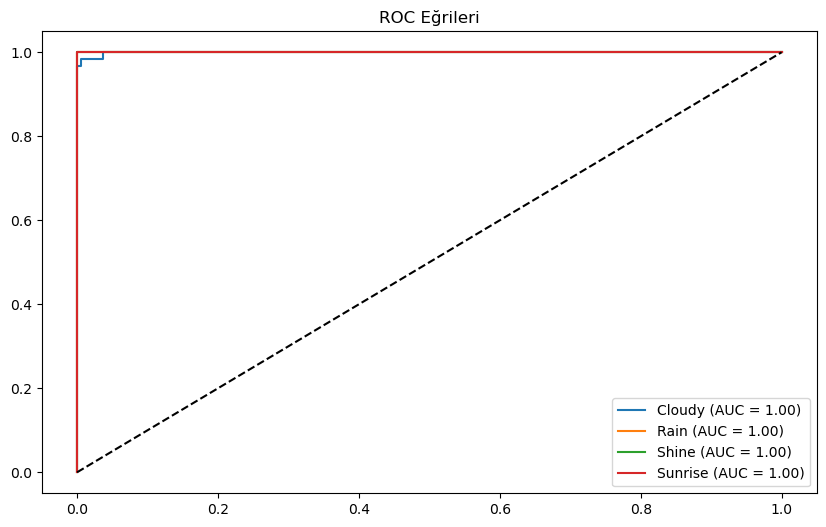

In [28]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# 5. Detaylı Performans Analizi (Test Seti) - Rapor Kısmı Çıkarıldı
def evaluate_detailed(model, dataloader, class_names):
    model.eval()
    y_true, y_pred, y_score = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_score.extend(probs.cpu().numpy())
    
    y_true, y_pred, y_score = np.array(y_true), np.array(y_pred), np.array(y_score)

    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (DenseNet121)'); plt.show()
    
    # (Sınıflandırma Raporu print komutları buradan kaldırıldı)

    # 2. ROC ve AUC
    y_test_bin = label_binarize(y_true, classes=range(len(class_names)))
    plt.figure(figsize=(10, 6))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], 'k--'); plt.title('ROC Eğrileri'); plt.legend(); plt.show()

# Fonksiyonu çağırmak için:
evaluate_detailed(model_ft, dataloaders['test'], class_names)

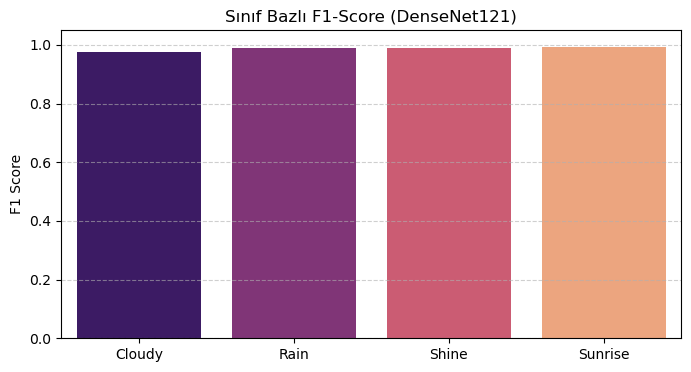

In [25]:
# --- TEST VERİLERİNİ HAZIRLAMA VE TAHMİN ---
model_ft.eval()
y_true = []
y_pred = []

# Test dataloader üzerinden geçerek tahminleri topla
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

from sklearn.metrics import classification_report

# Raporu sözlük olarak al
report = classification_report(
    y_true, y_pred, target_names=class_names, output_dict=True
)

# F1 skorlarını ayıkla
f1_scores = [report[c]['f1-score'] for c in class_names]

plt.figure(figsize=(8,4))
# hue ve legend ayarlarıyla hatasız grafik
sns.barplot(
    x=class_names,
    y=f1_scores,
    hue=class_names,
    palette="magma",
    legend=False
)

plt.ylim(0, 1.05)
plt.ylabel("F1 Score")
plt.title("Sınıf Bazlı F1-Score (DenseNet121)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

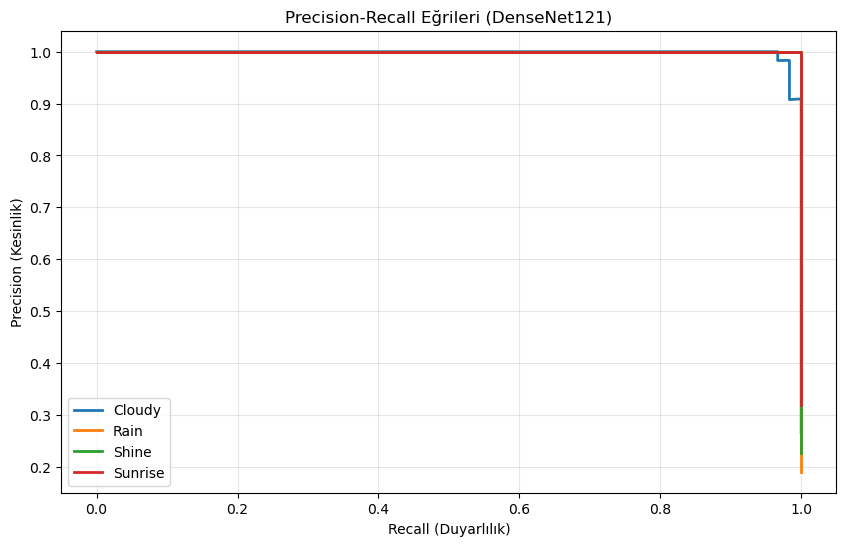

In [26]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# 1. Tahminleri ve Olasılık Skorlarını Topla
model_ft.eval()
y_true_list = []
y_score_list = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model_ft(inputs)
        
        # Olasılıkları hesapla (Softmax)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        
        y_true_list.extend(labels.cpu().numpy())
        y_score_list.extend(probs.cpu().numpy())

# Listeleri numpy dizisine çevir
y_true_arr = np.array(y_true_list)
y_score_arr = np.array(y_score_list)

# Etiketleri binarize et (One-vs-Rest formatı)
y_bin = label_binarize(y_true_arr, classes=range(len(class_names)))

# 2. Precision-Recall Eğrilerini Çiz
plt.figure(figsize=(10, 6))
for i in range(len(class_names)):
    p, r, _ = precision_recall_curve(y_bin[:, i], y_score_arr[:, i])
    plt.plot(r, p, lw=2, label=f"{class_names[i]}")

plt.xlabel("Recall (Duyarlılık)")
plt.ylabel("Precision (Kesinlik)")
plt.title("Precision-Recall Eğrileri (DenseNet121)")
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.show()

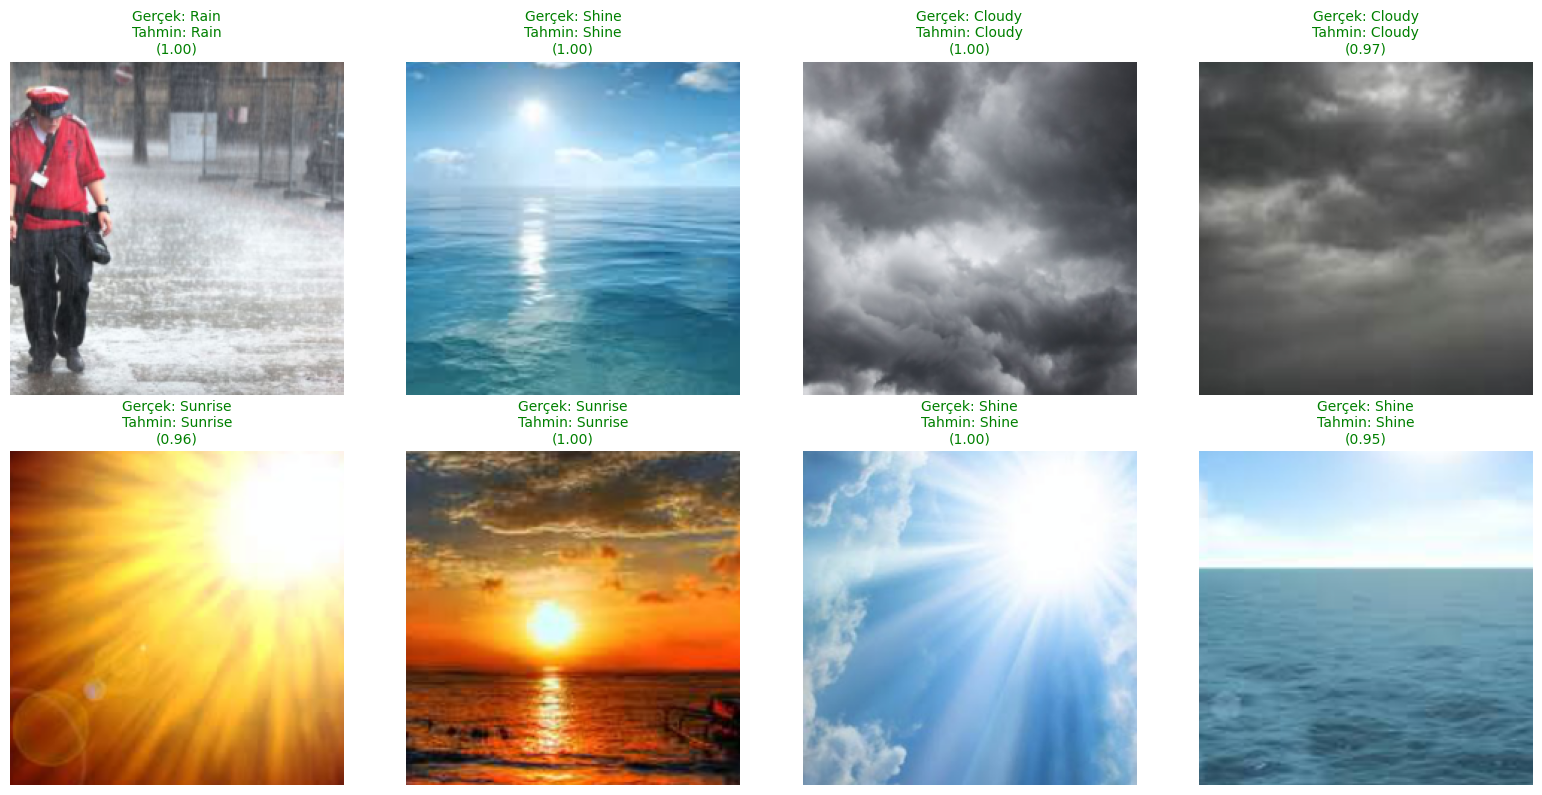


🎉 TEBRİKLER! DenseNet121 süreci tamamlandı.


In [27]:
# 6. Görsel Tahminler (Grid Şeklinde)
def show_sample_predictions(model, dataset, classes, n=8):
    model.eval()
    idxs = np.random.choice(len(dataset), n, replace=False)
    fig = plt.figure(figsize=(16, 8))
    for i, idx in enumerate(idxs):
        image, label = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor)
            probs = torch.nn.functional.softmax(output, dim=1)
            conf, pred_idx = torch.max(probs, 1)
        
        pred_label, true_label = classes[pred_idx.item()], classes[label]
        img_np = image.permute(1, 2, 0).numpy()
        img_np = np.clip(img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        
        ax = plt.subplot(2, n//2, i+1)
        plt.imshow(img_np)
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f"Gerçek: {true_label}\nTahmin: {pred_label}\n({conf.item():.2f})", color=color, fontsize=10)
        plt.axis('off')
    plt.tight_layout(); plt.show()

show_sample_predictions(model_ft, test_dataset, class_names, n=8)
print("\n🎉 TEBRİKLER! DenseNet121 süreci tamamlandı.")